# **Recommendation System (based on Ranking)**

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import**

Import modules and library needed

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from typing import Dict, Text

### **Prepare Dataset**

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Machine Learning/datasets/ratings.csv")
df.head()

,user_id,mountain_id,rating
0,1,126,3
1,1,127,3
2,1,171,4
3,9,156,1
4,9,207,5


In [5]:
print('Length of dataset rating :', len(df))

Length of dataset rating : 3232


In [7]:
#Unique User IDs and Mountain IDs 
unique_user_ids = len(df.user_id.unique())
unique_mountain_ids = len(df.mountain_id.unique())

print(unique_mountain_ids, 'Mountain IDs')
print(unique_user_ids, 'User IDs')

212 Mountain IDs
500 User IDs


## **Exploration**

In [8]:
#Popular Mountain
df.groupby('mountain_id')['rating'].mean().sort_values(ascending=False)[:10]

mountain_id
160    3.888889
90     3.866667
131    3.846154
105    3.727273
39     3.681818
11     3.666667
158    3.666667
179    3.647059
13     3.642857
31     3.600000
Name: rating, dtype: float64

In [10]:
#How often user goes hiking
df_freq = df.groupby('user_id').count().groupby('rating').count()
df_freq.columns = ['count']
df_freq.index.names = ['Hiking Frequency']
print(df_freq)

                  count
Hiking Frequency       
3                    60
4                    60
5                    66
6                    69
7                    63
8                    68
9                    57
10                   57


In [11]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.2, shuffle=True, random_state=88)

print('There are :', len(train), 'object on train examples')
print('There are :', len(val), 'object on val examples')

There are : 2585 object on train examples
There are : 647 object on val examples


## **Implementing Model**

In [66]:
embedding_dimension = 16

user_id = tf.keras.layers.Input(shape=[1], name="user_id")
user_embedding = tf.keras.layers.Embedding(unique_user_ids + 1, embedding_dimension)(user_id)

mountain_id = tf.keras.layers.Input(shape=[1], name="mountain_id")
mountain_embedding = tf.keras.layers.Embedding(unique_mountain_ids + 1, embedding_dimension)(mountain_id)

x = tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, mountain_embedding])
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)

In [67]:
# Create model and compile it
model = tf.keras.Model([user_id, mountain_id], x)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 mountain_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 16)        8016        ['user_id[0][0]']                
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 16)        3408        ['mountain_id[0][0]']            
                                                                                            

In [68]:
#Compile
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=["mae", "mse"], optimizer='Adagrad')

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# Train the model
history = model.fit([train.user_id, train.mountain_id], train.rating, epochs=150, callbacks=[lr_schedule])

(1e-08, 0.3, 0.0, 10.0)

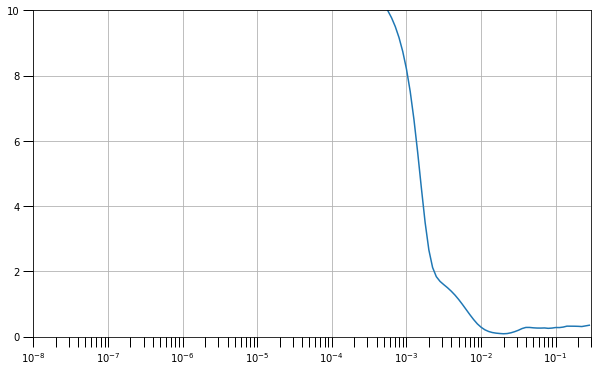

In [70]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Plot
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 0.3, 0, 10])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),loss=tf.keras.losses.MeanSquaredError(), metrics=["mae", "mse"])
model.fit([train.user_id, train.mountain_id], train.rating, epochs=100)

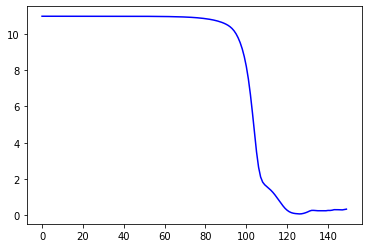

In [72]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [76]:
#Evaluate
model.evaluate([val.user_id, val.mountain_id], val.rating, return_dict=True)

21/21 [==============================] - 0s 2ms/step - loss: 3.5834 - mae: 1.5365 - mse: 3.5834


{'loss': 3.5834338665008545,
 'mae': 1.536512017250061,
 'mse': 3.5834338665008545}

In [74]:
#Test 
test_ratings = {}
test_mountain_ids = np.array(list(set(df.mountain_id)))
for mountain_id in test_mountain_ids:
  test_ratings[mountain_id] = model({
      "user_id": np.array([5]),
      "mountain_id": np.array([mountain_id])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True)[:10]:
  print(f"{title}: {score}")

Ratings:
92: [[4.9998536]]
69: [[4.99604]]
7: [[4.6039243]]
153: [[4.214825]]
48: [[4.12534]]
152: [[4.1161265]]
185: [[3.834145]]
212: [[3.8170996]]
13: [[3.7286391]]
165: [[3.7188036]]


## **Saved and Convert Model**

In [77]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('recommendation_rankingbased(dim16).h5')

In [78]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('recommendation_rankingbased(dim16).h5')

# Show the model architecture
new_model.summary()

new_model.evaluate([val.user_id, val.mountain_id], val.rating, return_dict=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 mountain_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 16)        8016        ['user_id[0][0]']                
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 16)        3408        ['mountain_id[0][0]']            
                                                                                            

{'loss': 3.5834338665008545,
 'mae': 1.536512017250061,
 'mse': 3.5834338665008545}